# Portfolio Construction & Stacking

This notebook implements the portfolio construction phase of the research project. It constructs TSMOM and Carry portfolios using volatility scaling and stacks them using various methods (Equal Weight, Risk Parity, Dynamic Ridge).

**Key Steps:**
1.  **Volatility Estimation:** EWMA volatility for each asset.
2.  **Signal Weighting:** Volatility-scaled weights ($w_{i,t} = \frac{V_{target}}{\sigma_{i,t}} \times s_{i,t}$).
3.  **Portfolio Construction:**
    *   **TSMOM:** Aggregated across time horizons (3m, 6m, 12m).
    *   **Carry:** Sleeve-neutral carry signal.
4.  **Stacking:**
    *   Equal Weight (50/50)
    *   Risk Parity
    *   Dynamic Ridge Regression (Minimum Variance with turnover penalty)
5.  **Advanced Analysis:**
    *   Rolling Correlations
    *   Underwater Plots (Drawdowns)
    *   Monthly Heatmaps
    *   Risk Metrics (Sharpe, Sortino, Calmar)


In [35]:
import sys
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure src is in path
sys.path.append(os.path.abspath('..'))

from src.portfolio import (
    calculate_ewma_volatility,
    calculate_vol_scaled_weights,
    construct_tsmom_portfolio,
    construct_carry_portfolio,
    stack_portfolios
)
from src.analysis import (
    calculate_max_drawdown,
    calculate_sortino_ratio,
    calculate_calmar_ratio
)

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Data Loading

Here we load the cleaned signal dataset and continuous returns.
We filter to front contracts so that each (date, asset) pair appears once.
Signals are then pivoted into wide matrices for TSMOM (3m, 6m, 12m) and Carry (carry_z).
Returns are also aligned to this structure.

In [46]:
# Load Data
DATA_DIR = '../data/processed'
signals_path = os.path.join(DATA_DIR, 'master_dataset_with_signals.parquet')
returns_path = os.path.join(DATA_DIR, 'continuous_returns.parquet')

logger.info(f"Loading signals from {signals_path}...")
df_signals = pd.read_parquet(signals_path)

logger.info(f"Loading returns from {returns_path}...")
df_returns = pd.read_parquet(returns_path)

# Ensure date is datetime
df_signals['date'] = pd.to_datetime(df_signals['date'])
if 'date' in df_returns.columns:
    df_returns['date'] = pd.to_datetime(df_returns['date'])
    df_returns = df_returns.set_index('date')

# Filter for front contracts only to avoid duplicates
if 'is_front' in df_signals.columns:
    df_signals = df_signals[df_signals['is_front']].copy()

# Pivot signals to wide format for easier processing
tsmom_3m = df_signals.pivot(index='date', columns='root', values='tsmom_3m')
tsmom_6m = df_signals.pivot(index='date', columns='root', values='tsmom_6m')
tsmom_12m = df_signals.pivot(index='date', columns='root', values='tsmom_12m')
carry_z = df_signals.pivot(index='date', columns='root', values='carry_z')

# Asset Class Map
asset_class_map = df_signals[['root', 'asset_class']].drop_duplicates().set_index('root')['asset_class'].to_dict()


2025-12-04 18:48:30,223 - INFO - Loading signals from ../data/processed/master_dataset_with_signals.parquet...
2025-12-04 18:48:30,293 - INFO - Loading returns from ../data/processed/continuous_returns.parquet...


## 2. Volatility Estimation (EWMA)

We compute EWMA volatility (λ = 0.94) for each asset using the return panel.
These volatility estimates are used to scale signal exposures and target a consistent risk level across assets.

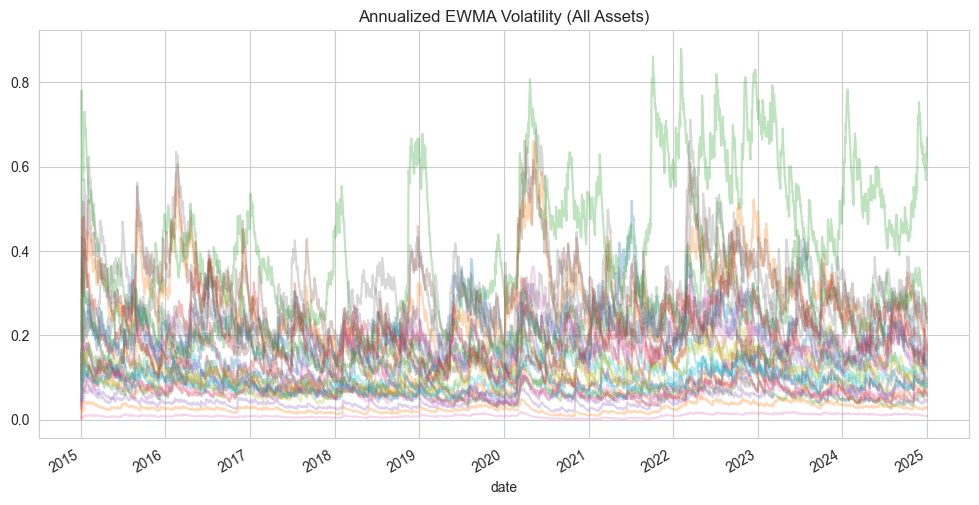

In [47]:
# Calculate EWMA Volatility
# We use the continuous returns dataset which should be wide (date x asset)
# If df_returns is not wide, pivot it
if 'root' in df_returns.columns:
    returns_wide = df_returns.pivot(index='date', columns='root', values='return')
else:
    returns_wide = df_returns

volatility = calculate_ewma_volatility(returns_wide, lam=0.94)

volatility.plot(title="Annualized EWMA Volatility", legend=False, alpha=0.3)
plt.title("Annualized EWMA Volatility (All Assets)")
plt.show()


In [57]:
volatility

root,6A,6B,6C,6E,6J,6N,6S,CL,ES,GC,...,UB,ZB,ZC,ZF,ZL,ZM,ZN,ZS,ZT,ZW
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,0.093485,0.155254,0.144815,0.026546,0.056500,0.103938,0.073343,0.232640,0.037966,0.073664,...,0.119429,0.082801,NaN,0.024373,NaN,NaN,0.049919,NaN,0.005618,NaN
2015-01-05,0.133428,0.157647,0.167788,0.053551,0.109232,0.156055,0.083104,0.184777,0.041892,0.159610,...,0.084372,0.059908,NaN,0.021540,NaN,NaN,0.037626,NaN,0.005138,NaN
2015-01-06,0.119950,0.136411,0.141701,0.044278,0.112803,0.173300,0.070707,0.169362,0.050485,0.146590,...,0.077285,0.050494,0.317818,0.020001,0.294253,0.302021,0.031328,0.295971,0.004576,0.063625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,0.094137,0.066358,0.057491,0.065142,0.081586,0.101731,0.068423,0.193532,0.077549,0.136869,...,0.117142,0.076834,0.129583,0.027140,0.254534,0.276484,0.043355,0.150797,0.008305,0.164482
2024-12-27,0.091308,0.066799,0.055827,0.063235,0.079118,0.099284,0.067271,0.190147,0.088451,0.135604,...,0.115376,0.076495,0.126206,0.026406,0.248106,0.276273,0.042578,0.148892,0.008054,0.165211
2024-12-29,0.089173,0.064771,0.054541,0.061418,0.076718,0.096742,0.065345,0.184463,0.085923,0.131489,...,0.112020,0.074312,0.123521,0.025651,0.241563,0.268232,0.041389,0.144425,0.007815,0.161338


## 3. TSMOM Portfolio Construction

We build a TSMOM portfolio by combining the 3m, 6m, and 12m signals.
Weights are scaled by volatility and then normalized to target 10% annualized volatility.
The resulting return series is shifted by one day to avoid lookahead.
The cumulative return plot shows how the aggregated trend strategy performs over time.

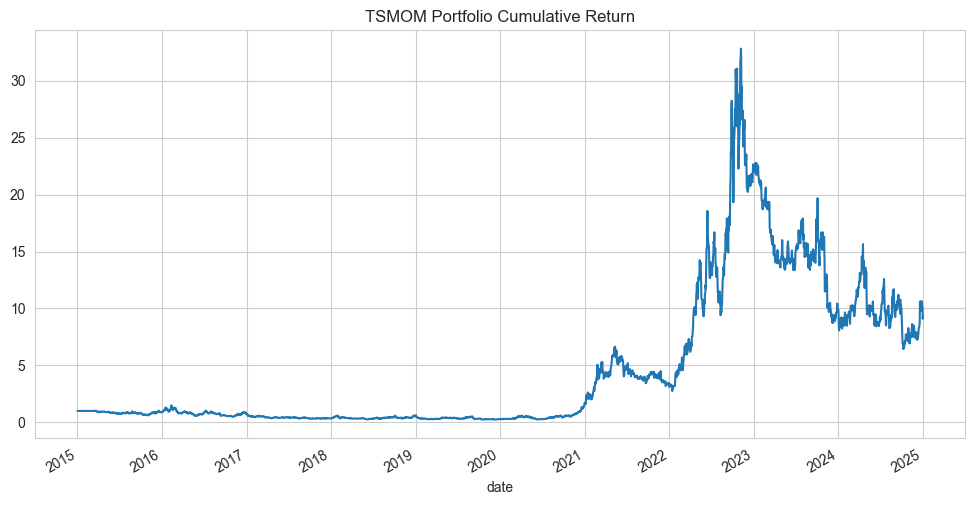

In [48]:
# Construct TSMOM Portfolio
# We aggregate signals across horizons (3m, 6m, 12m)
tsmom_signals = {
    '3m': tsmom_3m,
    '6m': tsmom_6m,
    '12m': tsmom_12m
}

# Calculate weights
tsmom_weights = construct_tsmom_portfolio(tsmom_signals, volatility, target_vol=0.10)

# Calculate Portfolio Returns (Shift weights by 1 to avoid lookahead)
tsmom_port_returns = (tsmom_weights.shift(1) * returns_wide).sum(axis=1)

(1 + tsmom_port_returns).cumprod().plot(title="TSMOM Portfolio Cumulative Return")
plt.show()


## 4. Carry Portfolio Construction

We construct the Carry portfolio using the carry_z signal.
Weights are again scaled using EWMA volatility and targeted to 10% vol.
Returns are computed the same way as TSMOM.
Carry tends to be higher-turnover and produces a different profile from TSMOM.

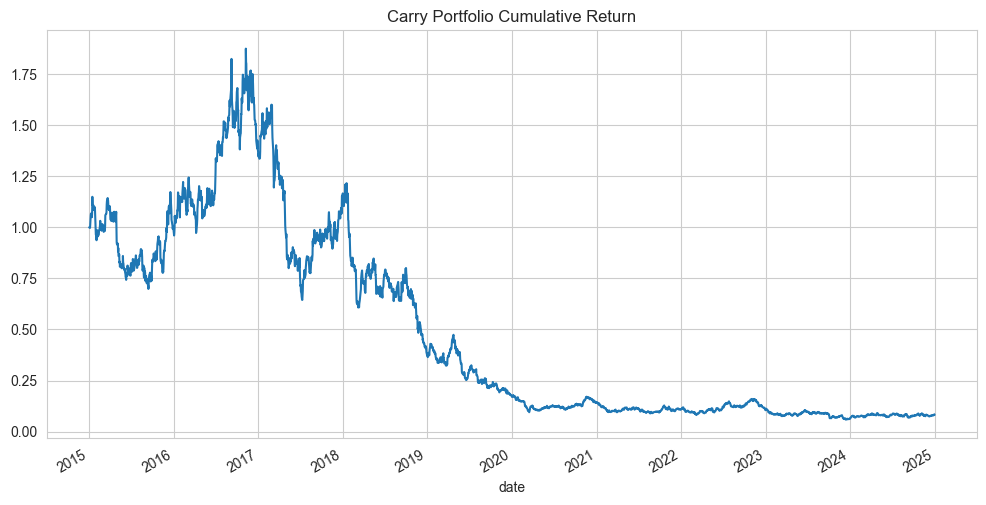

In [49]:
# Construct Carry Portfolio
carry_weights = construct_carry_portfolio(carry_z, volatility, asset_class_map, target_vol=0.10)

# Calculate Portfolio Returns
carry_port_returns = (carry_weights.shift(1) * returns_wide).sum(axis=1)

(1 + carry_port_returns).cumprod().plot(title="Carry Portfolio Cumulative Return")
plt.show()


## 5. Portfolio Stacking

We combine TSMOM and Carry into multi-strategy portfolios using three approaches:

* Equal weight (50/50)
* Risk parity (rolling window)
* Dynamic ridge regression (rolling, with turnover penalty)

This creates blended return streams that diversify the individual signals.

In [50]:
# Stack Portfolios
strategy_returns = pd.DataFrame({
    'TSMOM': tsmom_port_returns,
    'Carry': carry_port_returns
}).dropna()

# 1. Equal Weight
stack_equal = stack_portfolios(strategy_returns, method='equal')

# 2. Risk Parity
stack_rp = stack_portfolios(strategy_returns, method='risk_parity', window=60)

# 3. Dynamic Ridge
stack_ridge = stack_portfolios(strategy_returns, method='ridge', window=60, turnover_penalty=0.001)


## 6. Performance Analysis

We compare all strategies using cumulative returns and summary statistics:

* Annualized return and volatility
* Sharpe, Sortino, and Calmar ratios
* Maximum drawdown

These metrics help evaluate how stable and robust each method is.

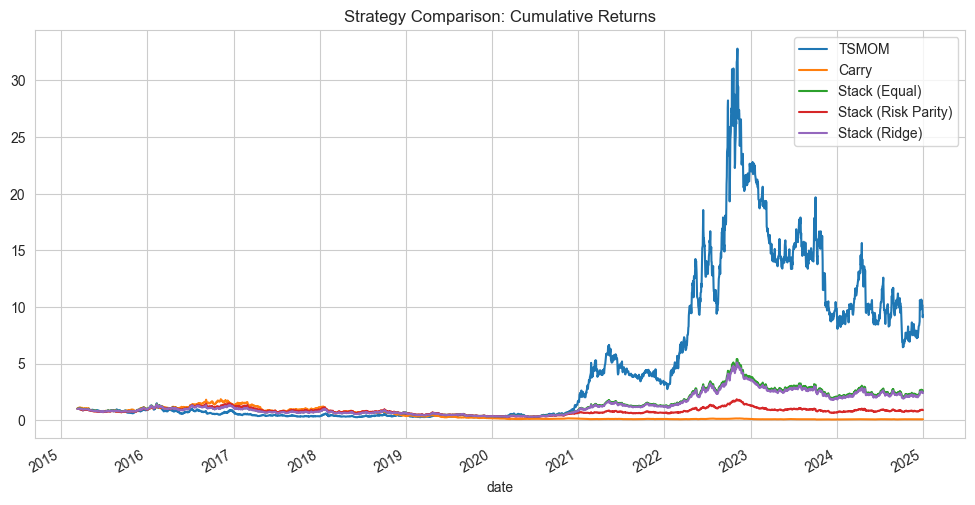

In [52]:
# Strategy Comparison
comparison = pd.DataFrame({
    'TSMOM': tsmom_port_returns,
    'Carry': carry_port_returns,
    'Stack (Equal)': stack_equal,
    'Stack (Risk Parity)': stack_rp,
    'Stack (Ridge)': stack_ridge
}).dropna()

# Cumulative Returns
(1 + comparison).cumprod().plot(title="Strategy Comparison: Cumulative Returns")
plt.show()


### 6.1 Risk Metrics Table

In [53]:
# Calculate Comprehensive Stats
def calculate_stats(ret):
    ann_ret = ret.mean() * 252
    ann_vol = ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else 0
    sortino = calculate_sortino_ratio(ret)
    calmar = calculate_calmar_ratio(ret)
    max_dd = calculate_max_drawdown(ret)
    
    return pd.Series({
        'Ann Return': f"{ann_ret:.2%}", 
        'Ann Vol': f"{ann_vol:.2%}", 
        'Sharpe': f"{sharpe:.2f}",
        'Sortino': f"{sortino:.2f}",
        'Calmar': f"{calmar:.2f}",
        'Max Drawdown': f"{max_dd:.2%}"
    })

stats = comparison.apply(calculate_stats)
display(stats)


,TSMOM,Carry,Stack (Equal),Stack (Risk Parity),Stack (Ridge)
Ann Return,47.21%,-12.58%,17.32%,6.25%,16.74%
Ann Vol,75.65%,40.34%,43.83%,37.96%,43.60%
Sharpe,0.62,-0.31,0.40,0.16,0.38
Sortino,0.89,-0.46,0.58,0.24,0.56
Calmar,0.56,-0.13,0.22,0.08,0.21
Max Drawdown,-83.63%,-96.87%,-79.14%,-80.63%,-79.23%


### 6.2 Rolling Correlations

We compute a rolling 6-month correlation between TSMOM and Carry.
This highlights how independent the signals are through different market conditions.

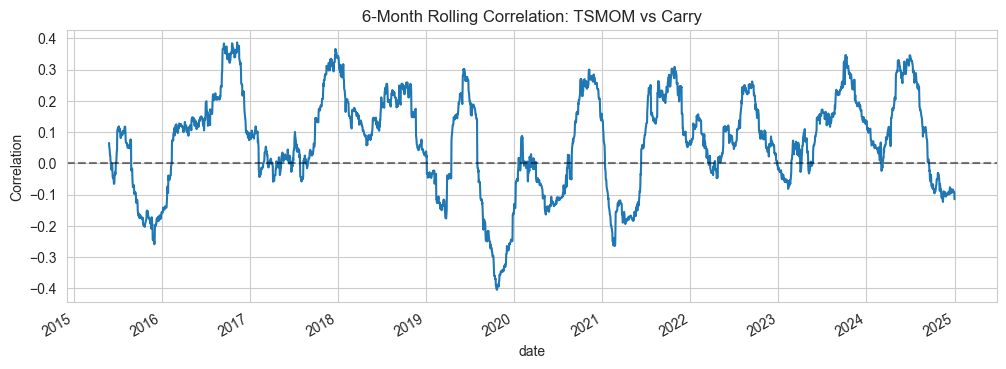

In [54]:
# Rolling Correlation between TSMOM and Carry
rolling_corr = strategy_returns['TSMOM'].rolling(window=126).corr(strategy_returns['Carry'])

plt.figure(figsize=(12, 4))
rolling_corr.plot(title="6-Month Rolling Correlation: TSMOM vs Carry")
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.ylabel("Correlation")
plt.show()


### 6.3 Drawdowns

We generate underwater plots to visualize drawdowns for each strategy.
This is useful for understanding tail behavior and risk during stress periods.

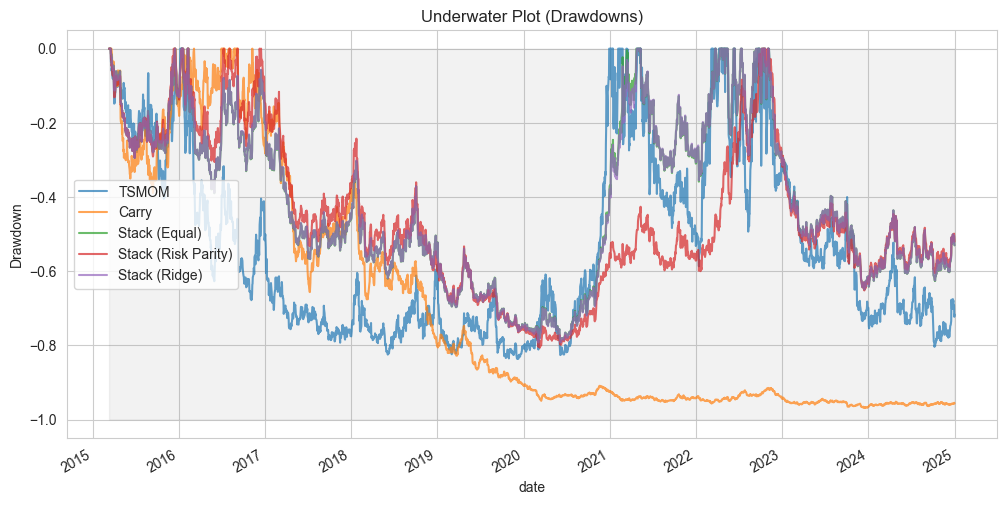

In [55]:
# Underwater Plot
def calculate_drawdown_series(returns):
    cum_ret = (1 + returns).cumprod()
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    return drawdown

drawdowns = comparison.apply(calculate_drawdown_series)

drawdowns.plot(title="Underwater Plot (Drawdowns)", alpha=0.7)
plt.ylabel("Drawdown")
plt.fill_between(drawdowns.index, 0, -1, color='gray', alpha=0.1)
plt.show()


### 6.4 Monthly Returns Heatmap (Stacked Ridge)

We compute monthly returns for the ridge-stacked portfolio and visualize them as a heatmap.
This shows how performance varies across years and months, making it easy to identify strong and weak periods.

/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_65076/936646937.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = stack_ridge.resample('M').apply(lambda x: (1 + x).prod() - 1)


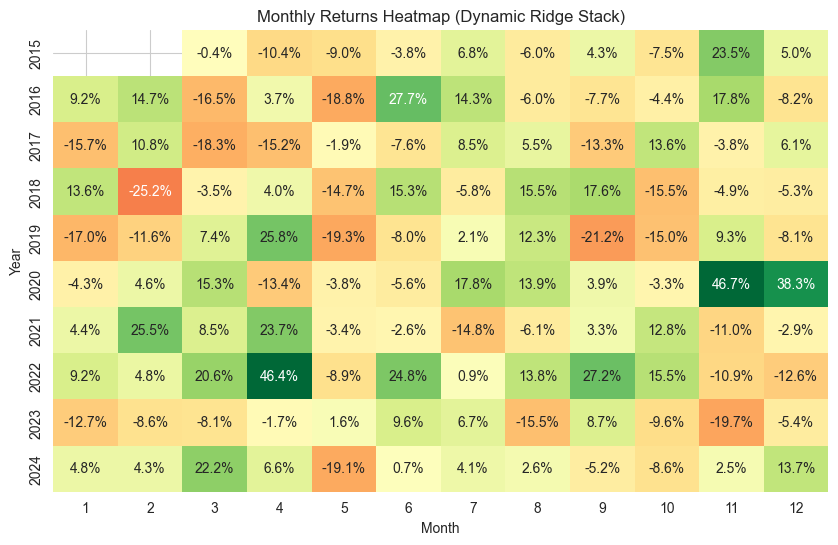

In [56]:
# Monthly Returns Heatmap for the Ridge Stack
monthly_returns = stack_ridge.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_returns_df = pd.DataFrame({
    'Year': monthly_returns.index.year,
    'Month': monthly_returns.index.month,
    'Return': monthly_returns.values
})

heatmap_data = monthly_returns_df.pivot(index='Year', columns='Month', values='Return')

plt.figure(figsize=(10, len(heatmap_data)/2 + 1))
sns.heatmap(heatmap_data, annot=True, fmt='.1%', cmap='RdYlGn', center=0, cbar=False)
plt.title("Monthly Returns Heatmap (Dynamic Ridge Stack)")
plt.show()
